In [3]:
import os
import pickle
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import faiss
from PIL import Image

plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["figure.dpi"] = 120

INDEX_PATH = Path("../outputs/embeddings/index.faiss")
META_PATH = Path("../outputs/embeddings/meta.pkl")

assert INDEX_PATH.exists(), f"FAISS index not found: {INDEX_PATH}"
assert META_PATH.exists(), f"Metadata not found: {META_PATH}"


In [ ]:
# 1. FAISS index + metadata 로드

# FAISS index 로드
index = faiss.read_index(str(INDEX_PATH))
n_vectors = index.ntotal
print(f"Index loaded. #vectors = {n_vectors}")

embeddings = index.reconstruct_n(0, n_vectors).astype(np.float32)   # shape: (N, D)
print("Embeddings shape:", embeddings.shape)

# 메타데이터 로드
with open(META_PATH, "rb") as f:
    metadata = pickle.load(f)

print("Metadata length:", len(metadata))

assert len(metadata) == n_vectors, "meta.pkl 길이와 index 벡터 수가 다름!"

# DataFrame 변환
meta_df = pd.DataFrame(metadata)
meta_df.head()


Index loaded. #vectors = 4410
Embeddings shape: (4410, 2048)
Metadata length: 4410


,image_name,image_path,row_idx,attributes
0,WOMEN-Skirts-id_00004947-01_1_front.jpg,data/raw/images/WOMEN-Skirts-id_00004947-01_1_...,0,"[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, ..."
1,WOMEN-Tees_Tanks-id_00003786-02_2_side.jpg,data/raw/images/WOMEN-Tees_Tanks-id_00003786-0...,1,"[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
2,WOMEN-Blouses_Shirts-id_00001846-01_2_side.jpg,data/raw/images/WOMEN-Blouses_Shirts-id_000018...,2,"[0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, ..."
3,WOMEN-Jackets_Coats-id_00002228-01_2_side.jpg,data/raw/images/WOMEN-Jackets_Coats-id_0000222...,3,"[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
4,WOMEN-Jackets_Coats-id_00007450-02_4_full.jpg,data/raw/images/WOMEN-Jackets_Coats-id_0000745...,4,"[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, ..."


In [ ]:
# 2. Attribute 벡터 정리 # meta.pkl 안의 attributes를 numpy array로 변환

meta_df = meta_df[meta_df["attributes"].notnull()].reset_index(drop=True)
print("Filtered meta_df length:", len(meta_df))

embeddings = embeddings[: len(meta_df)]
print("Embeddings shape after align:", embeddings.shape)

# attributes를 numpy array로 변환: (N, 18)
attr_array = np.stack(meta_df["attributes"].values).astype(np.float32)
print("Attributes shape:", attr_array.shape)

shape_attr = attr_array[:, :12]   
fabric_attr = attr_array[:, 12:15] 
pattern_attr = attr_array[:, 15:18]

shape_cls = shape_attr.argmax(axis=1)
fabric_cls = fabric_attr.argmax(axis=1)
pattern_cls = pattern_attr.argmax(axis=1)

meta_df["shape_cls"] = shape_cls
meta_df["fabric_cls"] = fabric_cls
meta_df["pattern_cls"] = pattern_cls

meta_df[["image_name", "shape_cls", "fabric_cls", "pattern_cls"]].head()


Filtered meta_df length: 4410
Embeddings shape after align: (4410, 2048)
Attributes shape: (4410, 18)


,image_name,shape_cls,fabric_cls,pattern_cls
0,WOMEN-Skirts-id_00004947-01_1_front.jpg,0,0,0
1,WOMEN-Tees_Tanks-id_00003786-02_2_side.jpg,0,0,0
2,WOMEN-Blouses_Shirts-id_00001846-01_2_side.jpg,1,0,0
3,WOMEN-Jackets_Coats-id_00002228-01_2_side.jpg,0,0,0
4,WOMEN-Jackets_Coats-id_00007450-02_4_full.jpg,0,0,0


PCA 대상 shape: (4410, 2048)


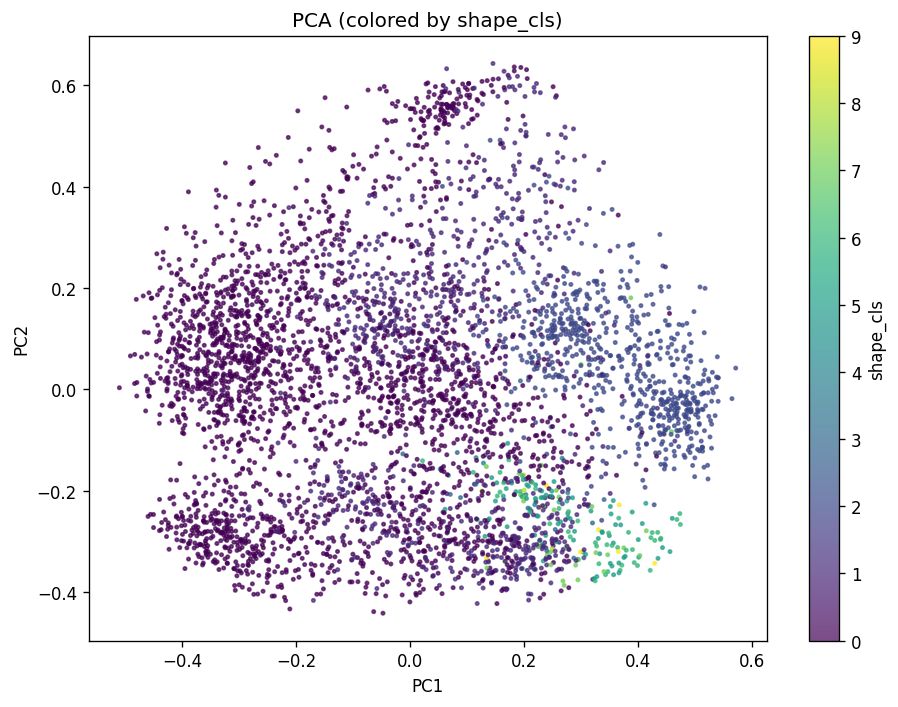

In [ ]:
# 3. PCA 2D 시각화 # 임베딩 벡터를 2차원으로 선형축소

MAX_POINTS = 5000
if len(embeddings) > MAX_POINTS:
    idx_sample = np.random.choice(len(embeddings), size=MAX_POINTS, replace=False)
    emb_pca = embeddings[idx_sample]
    shape_sample = meta_df["shape_cls"].values[idx_sample]
else:
    emb_pca = embeddings
    shape_sample = meta_df["shape_cls"].values

print("PCA 대상 shape:", emb_pca.shape)

pca = PCA(n_components=2)
pca_2d = pca.fit_transform(emb_pca)

plt.figure()
sc = plt.scatter(pca_2d[:, 0], pca_2d[:, 1],
                 c=shape_sample, s=4, alpha=0.7)
plt.colorbar(sc, label="shape_cls")
plt.title("PCA (colored by shape_cls)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()

t-SNE 대상 shape: (2000, 2048)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.004s...
[t-SNE] Computed neighbors for 2000 samples in 1.234s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.268473
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.351646
[t-SNE] KL divergence after 1000 iterations: 1.122976


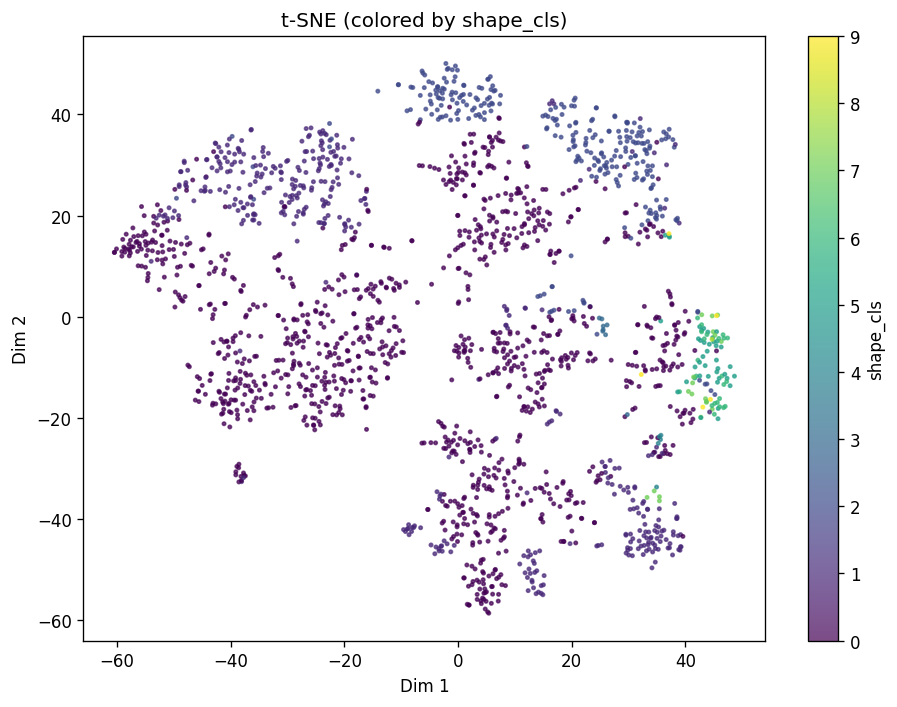

In [ ]:
# 4. t-SNE 2D 시각화 # 비선형 차원축소
TSNE_POINTS = 2000
if len(embeddings) > TSNE_POINTS:
    idx_tsne = np.random.choice(len(embeddings), size=TSNE_POINTS, replace=False)
    emb_tsne = embeddings[idx_tsne]
    shape_tsne = meta_df["shape_cls"].values[idx_tsne]
else:
    emb_tsne = embeddings
    shape_tsne = meta_df["shape_cls"].values

print("t-SNE 대상 shape:", emb_tsne.shape)

tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    init="random",
    random_state=42,
    verbose=1
)

tsne_2d = tsne.fit_transform(emb_tsne)

plt.figure()
sc = plt.scatter(tsne_2d[:, 0], tsne_2d[:, 1],
                 c=shape_tsne, s=4, alpha=0.7)
plt.colorbar(sc, label="shape_cls")
plt.title("t-SNE (colored by shape_cls)")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.tight_layout()
plt.show()

In [ ]:
# 5. Attribute 별 Retrieval Score

def compute_block_retrieval_scores(embeddings, attr_array, index, num_queries=200, top_k=5):
    """
    embeddings: (N, D)
    attr_array: (N, 18)
    index: faiss.Index
    """
    N = embeddings.shape[0]
    q_indices = np.random.choice(N, size=min(num_queries, N), replace=False)

    shape_slice = slice(0, 12)
    fabric_slice = slice(12, 15)
    pattern_slice = slice(15, 18)

    shape_scores = []
    fabric_scores = []
    pattern_scores = []

    for qi in q_indices:
        q_emb = embeddings[qi : qi+1].astype(np.float32)
        q_attr = attr_array[qi]

        dists, neigh_idx = index.search(q_emb, top_k + 1)
        neigh_idx = neigh_idx[0][1:]  
        neigh_attrs = attr_array[neigh_idx]  

        equal_mat = (neigh_attrs == q_attr).astype(np.float32) 
        mean_equal = equal_mat.mean(axis=0)

        shape_scores.append(mean_equal[shape_slice].mean())
        fabric_scores.append(mean_equal[fabric_slice].mean())
        pattern_scores.append(mean_equal[pattern_slice].mean())

    return {
        "shape": float(np.mean(shape_scores)),
        "fabric": float(np.mean(fabric_scores)),
        "pattern": float(np.mean(pattern_scores)),
    }


scores = compute_block_retrieval_scores(
    embeddings=embeddings,
    attr_array=attr_array,
    index=index,
    num_queries=300,
    top_k=5,
)

scores

{'shape': 0.8583889007568359,
 'fabric': 0.9353333711624146,
 'pattern': 0.9824444651603699}

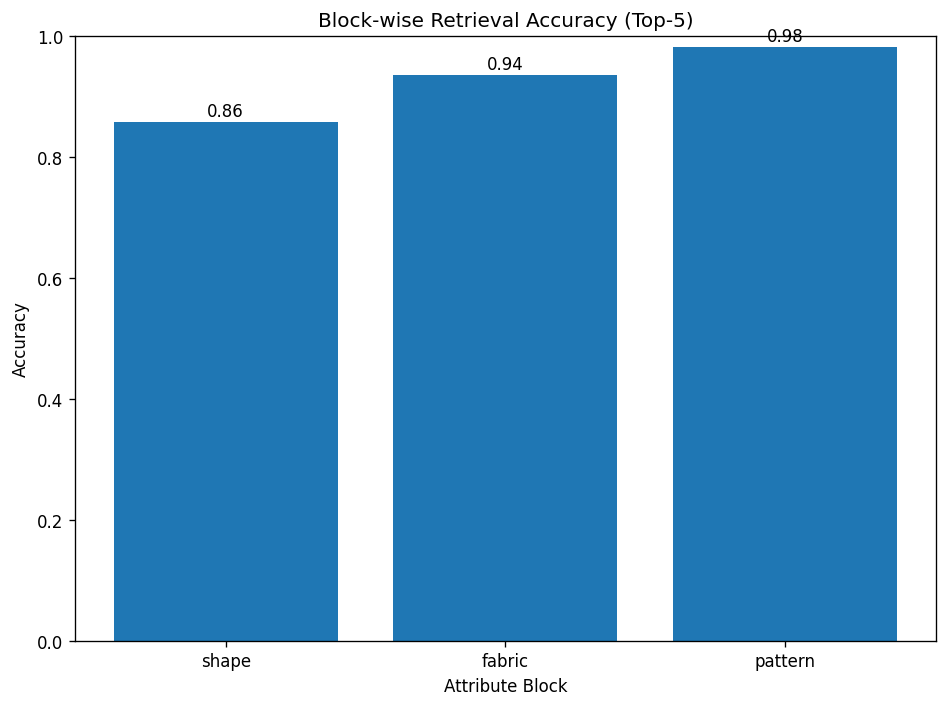

In [ ]:
# 6. Attribute 블록별 retrieval score bar plot

labels = list(scores.keys())
values = list(scores.values())

plt.figure()
plt.bar(labels, values)
plt.ylim(0, 1.0)
plt.title("Block-wise Retrieval Accuracy (Top-5)")
plt.xlabel("Attribute Block")
plt.ylabel("Accuracy")
for i, v in enumerate(values):
    plt.text(i, v + 0.01, f"{v:.2f}", ha="center")
plt.tight_layout()
plt.show()
